https://github.com/IlijahP/Data-wrangling-final
The price data can be downloaded at https://scryfall.com/docs/api/bulk-data. I used the Oracle Cards file. GitHub has the pre-scraped CSV for combos and salt, but the path will need to be adjusted on your end.


In [1]:
import json
import pandas as pd
import os
import re
import time
from bs4 import BeautifulSoup
import ast
import matplotlib.pyplot as plt
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.common.by import By
options = Options()
options = Options()
options.headless = True  
options.add_argument("--disable-gpu")
options.add_argument("--no-sandbox")
options.add_argument("--disable-dev-shm-usage")

# Introduction
Magic: The Gathering is a trading card game where players battle using decks they have built. Most decks rely on combos to win, A combo is a combination of cards that, when played together, have some sort of synergy. For example, a card might say "Deal 4 damage to a player whenever a token is created," and a second card may say "Whenever an opponent takes damage, create a 1/1 token goblin." If these two cards are on the table, all it would take would be an opponent taking damage for the two cards to be stuck in a loop dealing an infinite number of damage and creating an endless number of goblins. Not all combos are this straightforward or powerful, but this example should help you understand what a combo is. Since its creation in 1993, there are close to 27000 unique MTG cards. There are several different rulesets, but the one I am going to focus on is Commander, also known as Elder Dragon Highlander. EDH has the fewest card bans, allowing for the broadest spectrum of combos. An interesting dataset I am going to use is the saltiness score. The saltiness score is a survey that players take after they finish a game. The survey asks a simple question: how angry did this card make you? It's similar to leaving a Yelp review on a card. MTG cards also have a thriving resell market, directly linking a price to each card.

The research questions I will be answering are:
1. Do popular combos cost more?
2. Are salty combos more popular?
3. Are salty cards more expensive?


# Do popular combos cost more?
To answer the question "Do popular combos cost more?" I will first need to gather popular combo data and card price data. To get combo data, I will need to build a web scraper to get data from a combo sharing website. To get the price data I can download the most recent release from scryfall(https://scryfall.com/docs/api/bulk-data) an MTG information site that has data for anyone to use. Since the research question is gameplay-related, I will be using the cheapest, most affordable version of the card.

# Scraping combo data

In [2]:
combo_categories = [
    "mono-white", "mono-blue", "mono-black", "mono-red", "mono-green", "colorless",
    "azorius", "dimir", "rakdos", "gruul", "selesnya", "orzhov", "izzet", "golgari", "boros", "simic",
    "esper", "grixis", "jund", "naya", "bant", "abzan", "jeskai", "sultai", "mardu", "temur",
    "yore-tiller", "glint-eye", "dune-brood", "ink-treader", "witch-maw", "five-color"
]
all_combos = []

The Combo site I will be scraping is edhrec.com, an EDH-focused MTG combo and deck site. For this webscraper, I used Beautiful Soup, a popular webscraping library, to get all of the combos. Each card has a color identity, a combination of the five colors that make up almost all MTG cards(colorless cards exist, but that's besides the point). Each of the 32 color combinations has a unique "lore-related" name as another way to gatekeep newcomers. This is why the scraper navigates to https://edhrec.com/combos/{category} for each of the color categories above. It then scrolls to the bottom to load all the combos and pulls out each card in a combo for the cards column of the new combos dataframe, along with how many decks this combo appears in. This is done using regular expressions. Once the data is scraped, I put it in a CSV to avoid having to scrape it again. 

In [ ]:
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
for category in combo_categories:
    url = f"https://edhrec.com/combos/{category}"
    print(f"scraping {url}")
    driver.get(url)
    time.sleep(5)
    
    
    last_height = driver.execute_script("return document.body.scrollHeight")
    while True:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(3)
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height

    soup = BeautifulSoup(driver.page_source, 'html.parser')

    combo_entries = soup.select('div.Grid_cardlist__AXXsz.Grid_grouped__shX_l')

    for entry in combo_entries:
        combo_text = entry.select_one('a.Grid_header__iAPM8').text.strip()

        match = re.search(r'\(([\d,]+) decks\)', combo_text)
        if match:
            deck_count = int(match.group(1).replace(',', ''))
            cards_text = combo_text.split('(')[0].strip()
            cards = [card.strip() for card in cards_text.split('+')]
            all_combos.append({"cards": cards, "deck_count": deck_count})

combos_df = pd.DataFrame(all_combos)
combos_df.to_csv('combos.csv', index=False)
print(f"Total combos scraped: {len(combos_df)}")
print(combos_df.head())

In [4]:
combos_df = pd.read_csv("combos.csv") 
if isinstance(combos_df['cards'].iloc[0], str):
    combos_df['cards'] = combos_df['cards'].apply(ast.literal_eval)

I can load in the data from the csv using the cell above.

Now that I have the combos in a dataframe, I need the prices of each combo. To do this, I will load the Scryfall card price data from https://scryfall.com/docs/api/bulk-data. I am using the Oracle Cards JSON because it doesn't contain duplicates from alternative prints. Once I have the JSON loaded into a dataframe, I pull out prices along with names, and then I trim the price to be just USD from the most common version. 

In [5]:
price_path = 'C:/Users/Ilija/Downloads/oracle-cards-20250422210654.json'

with open(price_path, "r", encoding="utf-8") as f:
    all_cards = pd.read_json(f)

price_df = all_cards[['name', 'prices']].copy()
price_df['price'] = price_df['prices'].str.get('usd')
price_df = price_df[['name', 'price']]
print(price_df.head())

                       name  price
0  Nissa, Worldsoul Speaker   0.24
1                Static Orb  17.72
2       Sensory Deprivation   0.07
3            Road of Return   0.33
4                Storm Crow   0.05


I use .explode to let each card in the combo have their own row so I can then merge the cards and price. I use .to_numeric to convert the prices from strings to floating point numbers so that we can then sum and get the average price using .agg.


In [6]:
combos_ex = (combos_df.reset_index(names='combo_id').explode('cards').merge(price_df, left_on='cards', right_on='name', how='left'))

combos_ex['price'] = pd.to_numeric(combos_ex['price'])

combos_stats = (combos_ex.groupby('combo_id', as_index=False).agg(total_price = ('price', 'sum'), avg_price = ('price', 'mean'), num_cards   = ('cards', 'size')))

print(combos_stats.head())

   combo_id  total_price  avg_price  num_cards
0         0        23.57  11.785000          2
1         1         3.45   1.725000          2
2         2         9.52   4.760000          2
3         3        25.55   8.516667          3
4         4        48.12  24.060000          2


In [7]:
final_df = (combos_df.reset_index(names='combo_id').merge(combos_stats, on='combo_id').drop(columns='combo_id'))
final_df.head()

,cards,deck_count,total_price,avg_price,num_cards
0,"[Heliod, Sun-Crowned, Walking Ballista]",35688,23.57,11.785000,2
1,"[Felidar Guardian, Restoration Angel]",31952,3.45,1.725000,2
2,"[Luminous Broodmoth, Ashnod's Altar]",18739,9.52,4.760000,2
3,"[Preston, the Vanisher, Felidar Guardian, Ephe...",14112,25.55,8.516667,3
4,"[Luminous Broodmoth, Phyrexian Altar]",11741,48.12,24.060000,2


Text(0.5, 1.0, 'Combo popularity vs. average price')

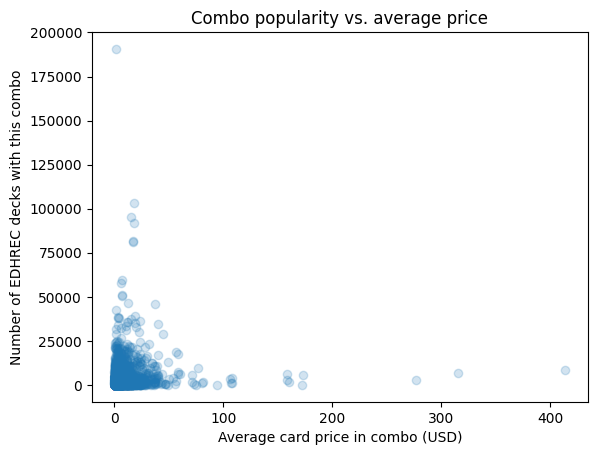

In [8]:
fig, ax = plt.subplots()
ax.scatter(final_df["avg_price"], final_df["deck_count"], alpha=0.2)

ax.set_xlabel("Average card price in combo (USD)")
ax.set_ylabel("Number of EDHREC decks with this combo")
ax.set_title("Combo popularity vs. average price")

Now that we have the graph, what does it mean? The first thing I notice looking at this graph is the sharp drop-off in popularity as the price goes up. This tells me that having a high price deters people from putting the combo in their deck. So, for the question, do popular combos cost more? This graph shows the opposite, that popular combos are more affordable combos.

# Are salty combos more popular?

To answer the question: Are salty combos more popular? I will need to scrape card saltiness data from edhrec.com. This will not be as easy as combos because now most of the data is hidden behind a load more button. Thankfully, I can use Selenium to click the JavaScript button.

In [ ]:
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)


driver.get("https://edhrec.com/top/salt")
time.sleep(2)

min_salt = 0.1
data = []
seen_cards = set()
stop_scraping = False

while not stop_scraping:
    soup = BeautifulSoup(driver.page_source, "html.parser")
    card_divs = soup.find_all("div", class_=re.compile(r"^Card_container__"))

    for card_div in card_divs:
        name = card_div.select_one("span[class^='Card_name__']")
        salt = card_div.select_one("div[class^='CardLabel_label__']")

        if not (name and salt):
            continue

        name = name.text.strip()


        salt = salt.get_text(" ", strip=True)
        m = re.search(r"Salt Score:\s*([\d\.]+)\s+([\d,]+)\s+decks", salt)
        if not m:
            continue

        salt = float(m.group(1).strip())
        deck_count = int(m.group(2).replace(",", "").strip())

        print(f"scraped {name} salt: {salt}")

        if salt <= min_salt:
            stop_scraping = True
            print(f"stopped at{min_salt}")
            break

        data.append({"name": name,
            "saltiness": salt,
            "deck_count": deck_count,})

    if stop_scraping:
        break

    try:
        btn = driver.find_element(By.XPATH, "//button[text()='Load More']")
        btn.click()
        time.sleep(2)
    except NoSuchElementException:
        print("No button")
        break

driver.quit()

salt_df = pd.DataFrame(data)
print(f" scraped {len(salt_df)}")



In [ ]:
salt_df = salt_df.drop_duplicates(subset="name", keep="first")
salt_df = salt_df.reset_index(drop=True)
salt_df.to_csv("salt.csv", index=False)

In [11]:
salt_df = pd.read_csv("salt.csv") 

In the code above, I use Selenium to press the load more button and Beautiful Soup to pull each card and its saltiness score. It continues to do this till it reaches a saltiness score of 0.1. The lower bound can be adjusted. The data is then saved to a CSV to avoid rescraping.

In [12]:
combos_ex = (combos_df.reset_index(names='combo_id').explode('cards').merge(salt_df, left_on='cards', right_on='name', how='left'))


combos_ex['saltiness'] = pd.to_numeric(combos_ex['saltiness'])

combos_stats = (combos_ex.groupby('combo_id', as_index=False).agg(total_salt = ('saltiness', 'sum'), avg_salt = ('saltiness', 'mean'), num_cards = ('cards', 'size')))

final_df = (combos_df.reset_index(names='combo_id').merge(combos_stats, on='combo_id').drop(columns='combo_id'))
final_df.head()

,cards,deck_count,total_salt,avg_salt,num_cards
0,"[Heliod, Sun-Crowned, Walking Ballista]",35688,2.14,1.070,2
1,"[Felidar Guardian, Restoration Angel]",31952,0.83,0.415,2
2,"[Luminous Broodmoth, Ashnod's Altar]",18739,1.40,0.700,2
3,"[Preston, the Vanisher, Felidar Guardian, Ephe...",14112,1.41,0.470,3
4,"[Luminous Broodmoth, Phyrexian Altar]",11741,1.48,0.740,2


This code is almost the same as the code used to merge the price and combo dataframes but instead of price it is now salt.

Text(0.5, 1.0, 'Combo popularity vs. average salt')

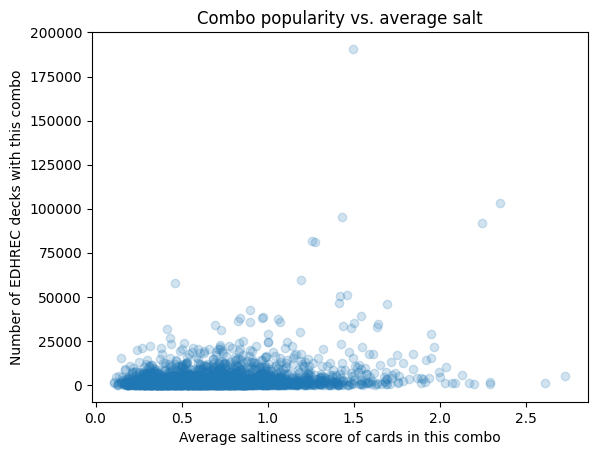

In [13]:
fig, ax = plt.subplots()
ax.scatter(final_df["avg_salt"], final_df["deck_count"], alpha=0.2)

ax.set_xlabel("Average saltiness score of cards in this combo")
ax.set_ylabel("Number of EDHREC decks with this combo")
ax.set_title("Combo popularity vs. average salt")

This graph shows some interesting insights. The main trend is that most combos aren't super popular, which makes sense because of the amount of playstyles and colors; there isn't any one combo for every deck. It is interesting to see that some of the most popular combos are high up in saltiness. To answer research question 2, Are salty combos more popular? No there does not seem to be any link between popularity and salt.

# Are salty cards more expensive?
To answer the final research question I will need to combine the price and salt datasets.

In [14]:
merged_df = price_df.merge(salt_df, on="name", how="inner")
merged_df = merged_df.dropna(subset=["price"]).reset_index(drop=True)
merged_df["saltiness"] = merged_df["saltiness"].fillna(0)
display(merged_df.head())

,name,price,saltiness,deck_count
0,Static Orb,17.72,2.80,19806
1,Ravnica at War,0.41,0.82,16149
2,Torrent of Fire,0.07,0.21,194
3,Nantuko Elder,0.98,0.11,7344
4,"Hua Tuo, Honored Physician",0.68,0.12,4257


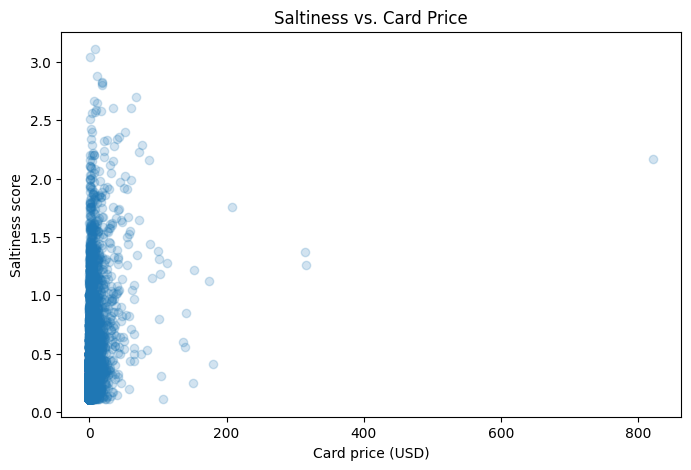

In [15]:
merged_df["price"] = pd.to_numeric(merged_df["price"])
fig, ax = plt.subplots(figsize=(8, 5))


ax.scatter(merged_df["price"], merged_df["saltiness"], alpha=0.2)

ax.set_xlabel("Card price (USD)")
ax.set_ylabel("Saltiness score")
ax.set_title("Saltiness vs. Card Price")
plt.show()

This graph shows that there is no overall trend when it comes to Saltines vs. Card Price. There is an affordable version for every level of salt. It does seem that as the price goes up, salt also increases but with so few data points the effect is weak.

# Conclusion

In conclusion, there is no link between saltiness, combo popularity, or price. While it's disappointing not to find any strong relationships. It is good to know that the game is balanced enough for all levels of salt at any price. Another key takeaway is that cheap combos are more popular. Looking back, it seems obvious, but now we have graphs to back it up.